In [1]:
from math import sqrt
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from synthesized.core import BasicSynthesizer, SeriesSynthesizer
from synthesized.core.values import CategoricalValue, ContinuousValue
from synthesized.testing.evaluation import Evaluation

os.getcwd()
evaluation = Evaluation(config_path='../synthesized/configs/evaluation/synthetic_distributions.json', name='synthetic')
#evaluation = Evaluation()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2D31-322D-B531
Expires at: 2019-12-31 00:00:00


In [3]:
def create_ball(x_mean, x_std, y_mean, y_std, size):
    mean = [x_mean, y_mean]
    cov = [[x_std, 0], [0, y_std]]
    x, y = np.random.multivariate_normal(mean, cov, size).T
    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [4]:
def create_line(x_range, intercept, slope, y_std, size):
    x = np.random.uniform(low=x_range[0], high=x_range[1], size=size)
    y = intercept + x*slope + np.random.normal(loc=0, scale=y_std, size=size)
    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [5]:
from scipy.stats import powerlaw
def create_power_law_distribution(a, scale, size):
    return pd.DataFrame({'x': scale*powerlaw.rvs(a, size=size)})

In [6]:
from scipy.stats import bernoulli
def create_bernoulli_distribution(ratio, size):
    df = pd.DataFrame({'x': bernoulli.rvs(ratio, size=size)})
    return df

In [7]:
def create_conditional_distibution(*norm_params, size):
    df = pd.DataFrame()
    for i, (mean, std) in enumerate(norm_params):
        x = [i] * size
        y = np.random.normal(mean, std, size)
        df = df.append(pd.DataFrame({'x': x, 'y': y}), ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [8]:
def create_unifom_categorical(n_classes, size):
    df = pd.DataFrame({'x': range(n_classes)})
    df = df.sample(10000, replace=True)
    return df

In [9]:
def create_power_law_categorical(n_classes, size):
    sample = [j for i in range(n_classes) for j in [i]*2**(n_classes-i-1)]
    df = pd.DataFrame({'x': sample})
    df = df.sample(10000, replace=True)
    return df

In [10]:
def plot_data(data, ax, value_types):
    if len(value_types) == 1:
        if value_types['x'] is CategoricalValue:
            return sns.distplot(data, ax=ax, kde=False)
        else:
            return sns.distplot(data, ax=ax)
    elif len(value_types) == 2:
        assert value_types['y'] is ContinuousValue
        if value_types['x'] is CategoricalValue:
            sns.violinplot(x="x", y="y", data=data, ax=ax)
        else:
            #return sns.jointplot(x="x", y="y", data=data, kind="kde", ax=ax)
            return ax.hist2d(data['x'], data['y'], bins=100)
    else:
        assert False

In [11]:
def synthesize_and_plot(data, name, num_iterations=None):
    if num_iterations is None:
        num_iterations = evaluation.config['num_iterations']
    start = time.time()
    with BasicSynthesizer(data=data, **evaluation.config['params']) as synthesizer:
        print('value types:')
        for value in synthesizer.values:
            print(value.name, value)
        value_types = {value.name: type(value) for value in synthesizer.values}
        synthesizer.learn(data=data, num_iterations=num_iterations, verbose=250)
        print()
        print('took', time.time() - start, 's')
        synthesized = synthesizer.synthesize(n=len(data))
        distances = [ks_2samp(data[col], synthesized[col])[0] for col in data.columns]
        avg_distance = np.mean(distances)
        evaluation[name + '_avg_distance'] = avg_distance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('original')
        ax2.set_title('synthesized')
        plot_data(data, ax=ax1, value_types=value_types)
        plot_data(synthesized, ax=ax2, value_types=value_types)

### Gauss "ball" outside of center

In [12]:
data = create_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
value types:
x continuous-normal-positive
y continuous-weibull-positive

iteration: 1
loss: total=1.62e+01 (encoding=14.011312484741211, x=1.083646535873413, y=1.1065610647201538, regularization=4.961407103110105e-05)
KS distances: avg=0.45 (x=0.44, y=0.46)

iteration: 125
loss: total=5.47e+00 (encoding=5.0620222091674805, x=0.17514750361442566, y=0.23718783259391785, regularization=6.598765321541578e-05)
KS distances: avg=0.04 (x=0.04, y=0.04)

iteration: 250
loss: total=5.20e+00 (encoding=4.814540386199951, x=0.19363945722579956, y=0.1963338553905487, regularization=7.015069422777742e-05)
KS distances: avg=0.04 (x=0.03, y=0.04)

iteration: 500
loss: total=5.30e+00 (encoding=4.985232353210449, x=0.16077864170074463, y=0.1584266722202301, regularization=7.836186705389991e-05)
KS distances: avg=0.04 (x=0.04, y=0.04)

iter

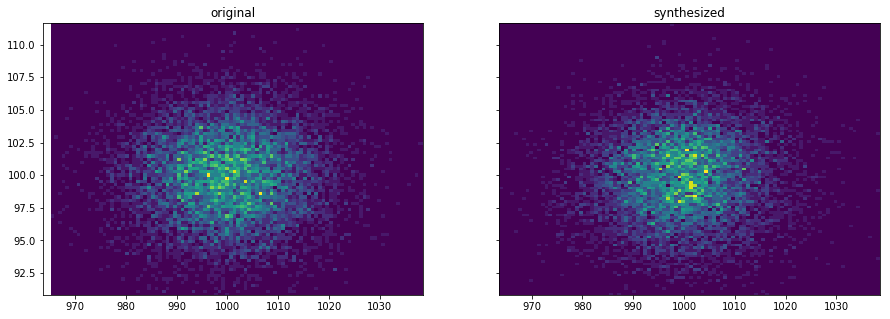

In [13]:
synthesize_and_plot(data, name='ball')

### Gauss "ball" around of zero

In [14]:
data = create_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000)

value types:
x continuous-normal
y continuous-weibull

iteration: 1
loss: total=1.59e+01 (encoding=13.732955932617188, x=1.1334360837936401, y=1.0834529399871826, regularization=4.949658250552602e-05)
KS distances: avg=0.44 (x=0.45, y=0.43)

iteration: 125
loss: total=5.38e+00 (encoding=5.024960994720459, x=0.18899580836296082, y=0.16269803047180176, regularization=6.608465628232807e-05)
KS distances: avg=0.05 (x=0.05, y=0.05)

iteration: 250
loss: total=5.50e+00 (encoding=5.157410621643066, x=0.17764918506145477, y=0.16568970680236816, regularization=7.022220233920962e-05)
KS distances: avg=0.04 (x=0.04, y=0.03)

iteration: 500
loss: total=5.06e+00 (encoding=4.727846622467041, x=0.16473063826560974, y=0.16592660546302795, regularization=7.752234523650259e-05)
KS distances: avg=0.04 (x=0.04, y=0.04)

iteration: 750
loss: total=4.41e+00 (encoding=4.194818019866943, x=0.14085808396339417, y=0.07797684520483017, regularization=8.596820407547057e-05)
KS distances: avg=0.03 (x=0.04, y=0.01)

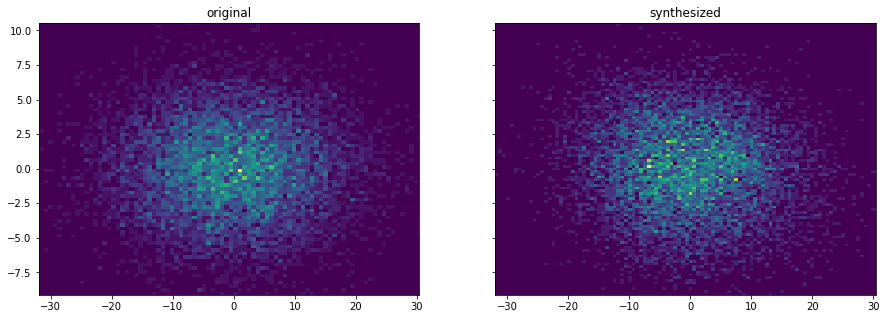

In [15]:
synthesize_and_plot(data, name='ball_ext')

### Line of noise that far from zero

In [16]:
data = create_line(x_range=(0, 1000), intercept=100, slope=-0.1, y_std=10, size=10000)

value types:
x continuous-uniform-positive
y continuous-normal


/Users/alexkuhnle/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/alexkuhnle/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



iteration: 1
loss: total=1.58e+01 (encoding=13.781256675720215, x=0.9690940380096436, y=1.0222655534744263, regularization=4.963916580891237e-05)
KS distances: avg=0.45 (x=0.45, y=0.46)

iteration: 125
loss: total=3.66e+00 (encoding=3.303649425506592, x=0.17640769481658936, y=0.18257755041122437, regularization=6.694102194160223e-05)
KS distances: avg=0.06 (x=0.05, y=0.07)

iteration: 250
loss: total=4.17e+00 (encoding=3.8911054134368896, x=0.14481937885284424, y=0.1300443857908249, regularization=7.383525371551514e-05)
KS distances: avg=0.06 (x=0.04, y=0.07)

iteration: 500
loss: total=4.09e+00 (encoding=3.874476909637451, x=0.11162544786930084, y=0.10664437711238861, regularization=8.66234622662887e-05)
KS distances: avg=0.06 (x=0.04, y=0.07)

iteration: 750
loss: total=3.07e+00 (encoding=2.8972370624542236, x=0.08801101893186569, y=0.08734127879142761, regularization=9.460731234867126e-05)
KS distances: avg=0.04 (x=0.03, y=0.05)

iteration: 1000
loss: total=2.76e+00 (encoding=2.648

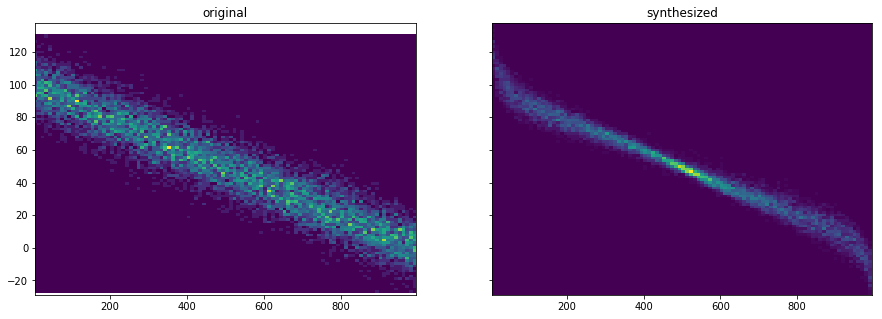

In [17]:
synthesize_and_plot(data, name='line')

### Line of noise that comes from zero

In [18]:
data = create_line(x_range=(0, 1000), intercept=0, slope=0.1, y_std=10, size=10000)

value types:
x continuous-uniform-positive
y continuous-normal

iteration: 1
loss: total=1.57e+01 (encoding=13.769828796386719, x=0.9419893026351929, y=1.0037710666656494, regularization=4.9168076657224447e-05)
KS distances: avg=0.45 (x=0.43, y=0.47)

iteration: 125
loss: total=3.78e+00 (encoding=3.498399496078491, x=0.14542719721794128, y=0.1407661736011505, regularization=6.641261279582977e-05)
KS distances: avg=0.05 (x=0.04, y=0.06)

iteration: 250
loss: total=3.82e+00 (encoding=3.539111614227295, x=0.14482644200325012, y=0.1374531388282776, regularization=7.313594687730074e-05)
KS distances: avg=0.07 (x=0.06, y=0.08)

iteration: 500
loss: total=3.63e+00 (encoding=3.369105100631714, x=0.12688353657722473, y=0.1372925043106079, regularization=8.562380389776081e-05)
KS distances: avg=0.06 (x=0.04, y=0.08)

iteration: 750
loss: total=3.55e+00 (encoding=3.294161796569824, x=0.1309521496295929, y=0.12296643853187561, regularization=9.334123751614243e-05)
KS distances: avg=0.04 (x=0.03, y

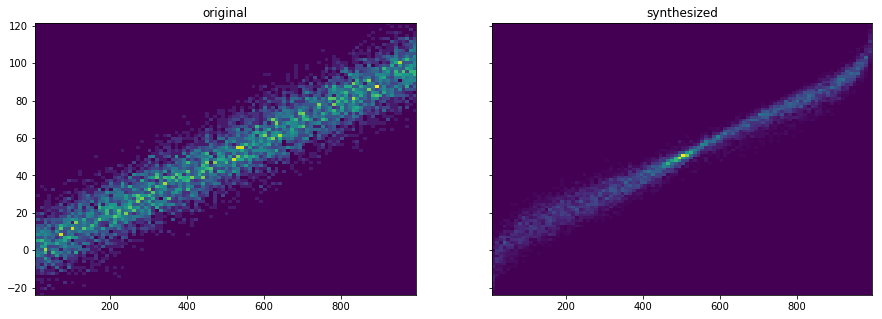

In [19]:
synthesize_and_plot(data, name='line_ext')

### Power law distribution

In [20]:
data = create_power_law_distribution(a=0.5, scale=1000, size=10000)

value types:
x continuous-gamma-positive

iteration: 1
loss: total=1.46e+01 (encoding=13.6699857711792, x=0.971595287322998, regularization=4.886790702585131e-05)
KS distances: avg=0.51 (x=0.51)

iteration: 125
loss: total=2.14e+00 (encoding=1.953627586364746, x=0.19067680835723877, regularization=6.463072350015864e-05)
KS distances: avg=0.09 (x=0.09)

iteration: 250
loss: total=2.61e+00 (encoding=2.4733879566192627, x=0.13874518871307373, regularization=7.048499537631869e-05)
KS distances: avg=0.09 (x=0.09)

iteration: 500
loss: total=2.47e+00 (encoding=2.325061559677124, x=0.14852070808410645, regularization=8.108069596346468e-05)
KS distances: avg=0.08 (x=0.08)

iteration: 750
loss: total=2.14e+00 (encoding=2.0263822078704834, x=0.11291380971670151, regularization=9.085112833417952e-05)
KS distances: avg=0.07 (x=0.07)

iteration: 1000
loss: total=1.70e+00 (encoding=1.6419910192489624, x=0.05506141856312752, regularization=9.593811410013586e-05)
KS distances: avg=0.04 (x=0.04)

took 

/Users/alexkuhnle/PycharmProjects/synthesized/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


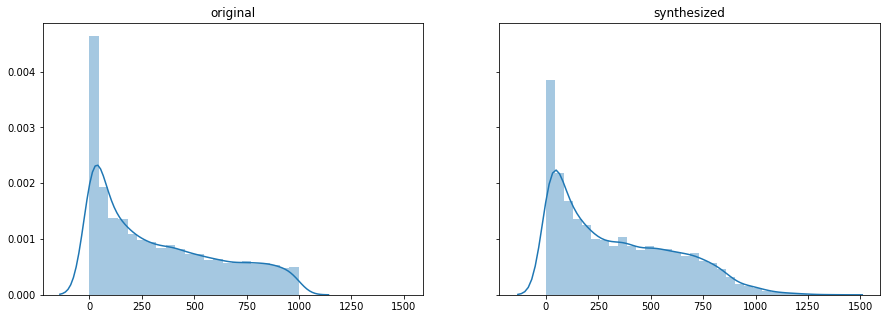

In [21]:
synthesize_and_plot(data, name='power_law')

### Conditional distribution

In [22]:
data = create_conditional_distibution((10,2), (20, 5), (30, 1), size=10000)

value types:
x categorical3-88
y continuous-gumbel

iteration: 1
loss: total=-9.31e+01 (encoding=13.909100532531738, x=-108.01551055908203, y=0.965488612651825, regularization=6.484858749900013e-05)
KS distances: avg=0.28 (x=0.05, y=0.50)

iteration: 125
loss: total=-1.05e+02 (encoding=3.2348906993865967, x=-108.3912582397461, y=0.11869747191667557, regularization=8.402517414651811e-05)
KS distances: avg=0.08 (x=0.04, y=0.12)

iteration: 250
loss: total=-1.05e+02 (encoding=2.839468240737915, x=-108.32120513916016, y=0.13079339265823364, regularization=9.227367991115898e-05)
KS distances: avg=0.07 (x=0.01, y=0.13)

iteration: 500
loss: total=-1.05e+02 (encoding=2.9602837562561035, x=-108.24359893798828, y=0.09966818988323212, regularization=0.00010460898920428008)
KS distances: avg=0.09 (x=0.01, y=0.16)

iteration: 750
loss: total=-1.05e+02 (encoding=2.767953395843506, x=-108.27113342285156, y=0.08340293914079666, regularization=0.00011345856182742864)
KS distances: avg=0.08 (x=0.03, y=

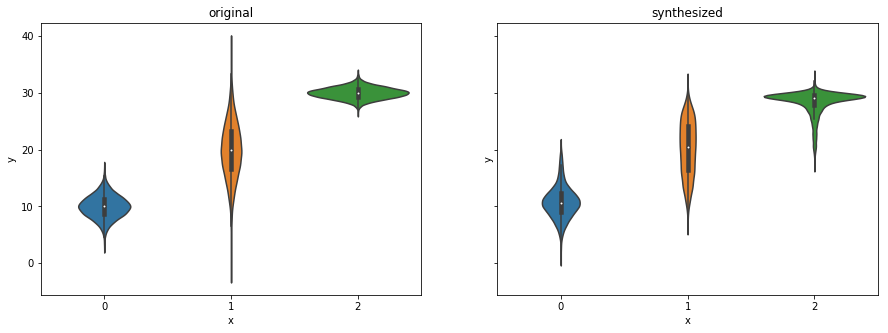

In [23]:
synthesize_and_plot(data, name='conditional')

### Bernoulli distribution

In [24]:
data = create_bernoulli_distribution(ratio=0.5, size=10000)

value types:
x categorical2-70

iteration: 1
loss: total=-5.51e+01 (encoding=13.505508422851562, x=-68.65349578857422, regularization=5.996375693939626e-05)
KS distances: avg=0.00 (x=0.00)

iteration: 125
loss: total=-6.89e+01 (encoding=0.48524996638298035, x=-69.37909698486328, regularization=4.185990837868303e-05)
KS distances: avg=0.00 (x=0.00)

iteration: 250
loss: total=-6.87e+01 (encoding=0.6422440409660339, x=-69.30931091308594, regularization=4.34673456766177e-05)
KS distances: avg=0.03 (x=0.03)

iteration: 500
loss: total=-6.86e+01 (encoding=0.7116991281509399, x=-69.34489440917969, regularization=4.574761260300875e-05)
KS distances: avg=0.02 (x=0.02)

iteration: 750
loss: total=-6.86e+01 (encoding=0.7374653220176697, x=-69.38592529296875, regularization=4.8398200306110084e-05)
KS distances: avg=0.01 (x=0.01)

iteration: 1000
loss: total=-6.88e+01 (encoding=0.4724242687225342, x=-69.30561065673828, regularization=5.09389465150889e-05)
KS distances: avg=0.01 (x=0.01)

took 14.9

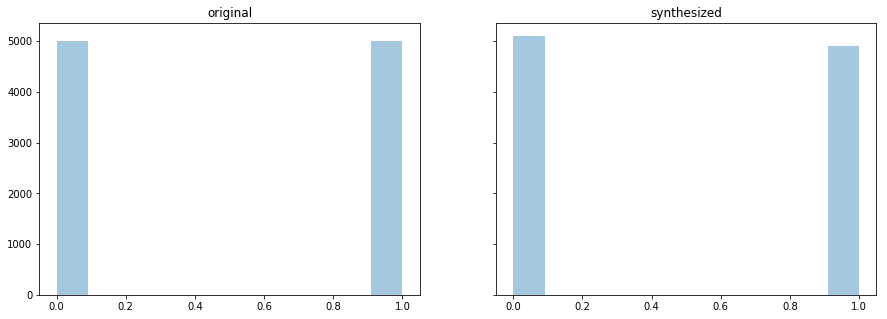

In [25]:
synthesize_and_plot(data, name='bernoulli_50/50')

In [26]:
data = create_bernoulli_distribution(ratio=0.2, size=10000)

value types:
x categorical2-70

iteration: 1
loss: total=-5.47e+01 (encoding=13.917932510375977, x=-68.63761901855469, regularization=6.030312579241581e-05)
KS distances: avg=0.60 (x=0.60)

iteration: 125
loss: total=-6.88e+01 (encoding=0.519540011882782, x=-69.3368148803711, regularization=5.388270437833853e-05)
KS distances: avg=0.03 (x=0.03)

iteration: 250
loss: total=-6.88e+01 (encoding=0.5270931720733643, x=-69.30595397949219, regularization=5.4156371334102005e-05)
KS distances: avg=0.03 (x=0.03)

iteration: 500
loss: total=-6.89e+01 (encoding=0.36387020349502563, x=-69.27610778808594, regularization=5.619236617349088e-05)
KS distances: avg=0.02 (x=0.02)

iteration: 750
loss: total=-6.87e+01 (encoding=0.517056405544281, x=-69.19227600097656, regularization=5.7944285799749196e-05)
KS distances: avg=0.04 (x=0.04)

iteration: 1000
loss: total=-6.88e+01 (encoding=0.4110313653945923, x=-69.2506332397461, regularization=6.0973379731876776e-05)
KS distances: avg=0.05 (x=0.05)

took 15.2

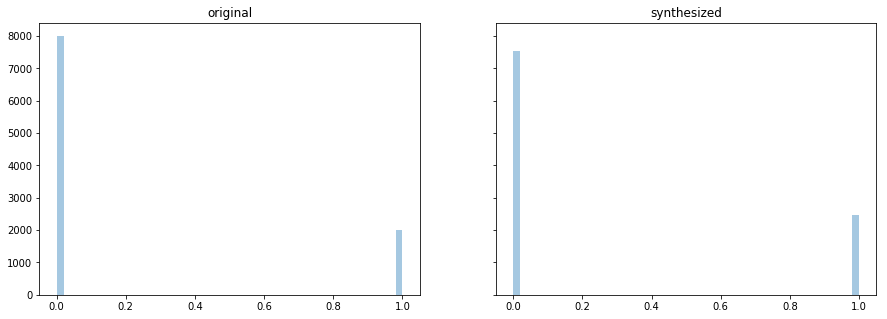

In [27]:
synthesize_and_plot(data, name='bernoulli_20/80')

### Categorical distribution

In [28]:
data = create_unifom_categorical(n_classes=10, size=10000)

value types:
x categorical10-153

iteration: 1
loss: total=-2.05e+02 (encoding=13.96717643737793, x=-218.83534240722656, regularization=8.044276910368353e-05)
KS distances: avg=0.08 (x=0.08)

iteration: 125
loss: total=-2.13e+02 (encoding=5.8592376708984375, x=-218.51882934570312, regularization=0.00010040700726676732)
KS distances: avg=0.01 (x=0.01)

iteration: 250
loss: total=-2.10e+02 (encoding=5.976477146148682, x=-216.3054962158203, regularization=0.00012445662287063897)
KS distances: avg=0.02 (x=0.02)

iteration: 500
loss: total=-2.09e+02 (encoding=6.044373035430908, x=-215.02951049804688, regularization=0.00016072136349976063)
KS distances: avg=0.02 (x=0.02)

iteration: 750
loss: total=-2.09e+02 (encoding=6.088603973388672, x=-215.0101776123047, regularization=0.00018838148389477283)
KS distances: avg=0.01 (x=0.01)

iteration: 1000
loss: total=-2.09e+02 (encoding=6.11770486831665, x=-214.7898406982422, regularization=0.00021351539180614054)
KS distances: avg=0.04 (x=0.04)

took 

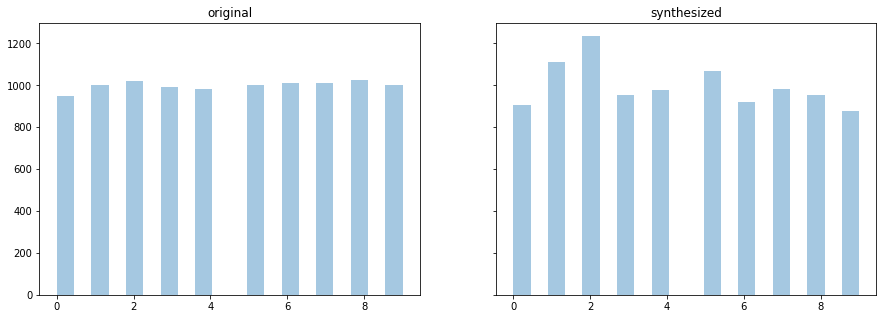

In [29]:
synthesize_and_plot(data, name='categorical_uniform')

In [30]:
data = create_power_law_categorical(n_classes=10, size=10000)

value types:
x categorical10-153

iteration: 1
loss: total=-2.08e+02 (encoding=13.761897087097168, x=-222.21502685546875, regularization=8.054125646594912e-05)
KS distances: avg=0.66 (x=0.66)

iteration: 125
loss: total=-2.21e+02 (encoding=2.9491326808929443, x=-224.11337280273438, regularization=9.355913789477199e-05)
KS distances: avg=0.06 (x=0.06)

iteration: 250
loss: total=-2.19e+02 (encoding=3.342210531234741, x=-222.76080322265625, regularization=0.00010847894009202719)
KS distances: avg=0.04 (x=0.04)

iteration: 500
loss: total=-2.18e+02 (encoding=3.3234241008758545, x=-221.55438232421875, regularization=0.00013155085616745055)
KS distances: avg=0.06 (x=0.06)

iteration: 750
loss: total=-2.19e+02 (encoding=3.2108383178710938, x=-221.7961883544922, regularization=0.0001533418253529817)
KS distances: avg=0.07 (x=0.07)

iteration: 1000
loss: total=-2.18e+02 (encoding=3.0696330070495605, x=-221.25283813476562, regularization=0.00017510895850136876)
KS distances: avg=0.04 (x=0.04)



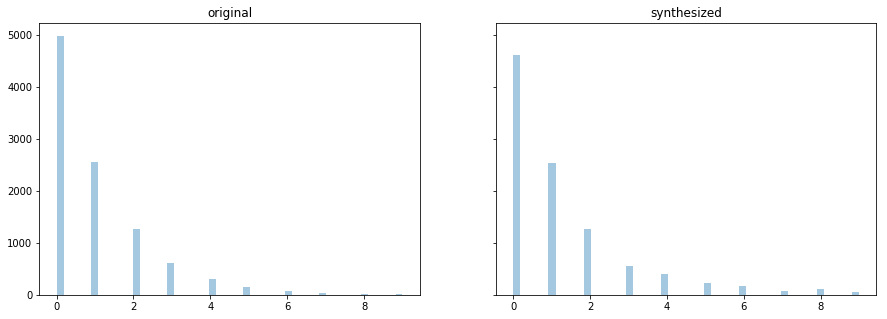

In [31]:
synthesize_and_plot(data, name='categorical_powerlaw')


In [32]:
evaluation.write_metrics()